### 0. 库的加载

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# opencv
import cv2
# 卷积层，-， -， 密集层， -， 丢掉神经元，
from keras.layers import Conv2D, Input, LeakyReLU, Dense, Activation, Flatten, Dropout, MaxPool2D
from keras import models
# 优化器
from keras.optimizers import Adam, RMSprop
# 预处理层
from keras.preprocessing.image import ImageDataGenerator
# 对学习率进行修改(会不断减少)
from keras.callbacks import ReduceLROnPlateau

### 1. 加载数据集

In [6]:
# 随机种子，确保每次运行结果一致
np.random.seed(666)

In [7]:
# 读取训练集
train_data = pd.read_csv("train.csv")

In [8]:
# 为了防止偶然性，把数据打乱
train_data = train_data.iloc[np.random.permutation(len(train_data))]

In [9]:
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
17664,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25895,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17700,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17990,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19836,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
train_data.shape
# 42000张图片，784个像素+标签列

(42000, 785)

### 2. 把数据集分割成训练集和验证集

In [13]:
# 数据集大小
train_size = train_data.shape[0]

In [14]:
# 验证集大小占比20%
val_size = int(train_size * 0.2)

In [15]:
# 验证集合
X_val = np.asarray(train_data.iloc[:val_size, 1:]).reshape([val_size, 28, 28, 1]) # 0是label
y_val = np.asarray(train_data.iloc[:val_size, 0]).reshape([val_size, 1]) # 标签

In [17]:
# 训练集
X_train = np.asarray(train_data.iloc[val_size:, 1:]).reshape([train_size - val_size, 28, 28, 1])
y_train = np.asarray(train_data.iloc[val_size:, 0]).reshape([train_size - val_size, 1]) # 标签

In [18]:
X_val.shape

(8400, 28, 28, 1)

In [19]:
X_train.shape

(33600, 28, 28, 1)

### 3. 加载测试集

In [20]:
test_data = pd.read_csv("test.csv")

In [21]:
X_test = np.asarray(test_data.iloc[:, :]).reshape([-1, 28, 28, 1])

In [23]:
X_test.shape

(28000, 28, 28, 1)

### 4. 正则化数据集

In [25]:
# 所以的像素值归一到0-1的范围内
X_train = X_train / 255.
X_val = X_val / 255.
X_test = X_test / 255.

### 5. 可视化训练集和验证集中不同数字出现的频次

In [27]:
counts = train_data.iloc[val_size:, :].groupby("label")["label"].count()

In [28]:
counts

label
0    3308
1    3762
2    3362
3    3478
4    3266
5    3018
6    3313
7    3519
8    3235
9    3339
Name: label, dtype: int64

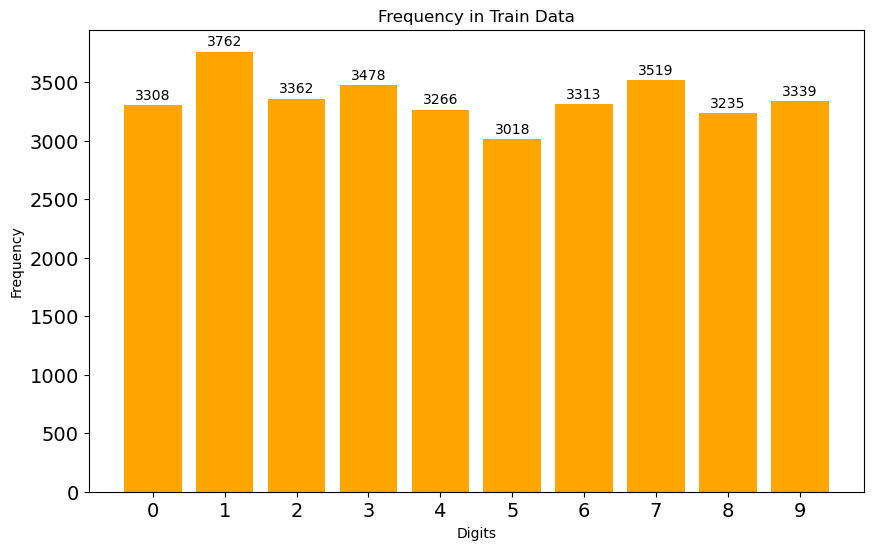

In [37]:
# 显示训练集
fig = plt.figure(figsize=(10, 6)) # 画布大小
fig.add_subplot(111) # 1行1列，位置
plt.bar(counts.index, counts.values, width=0.8, color='orange') # 柱状图的参数设置

# 循环：为柱状图中的每一个组装增加一个label
for i in counts.index:
    plt.text(i, counts.values[i]+50, str(counts.values[i]), horizontalalignment="center")

plt.tick_params(labelsize=14)
plt.xticks(counts.index)
plt.xlabel("Digits")
plt.ylabel("Frequency")
plt.title("Frequency in Train Data")
plt.savefig("digit_frequency_train.png")
plt.show()

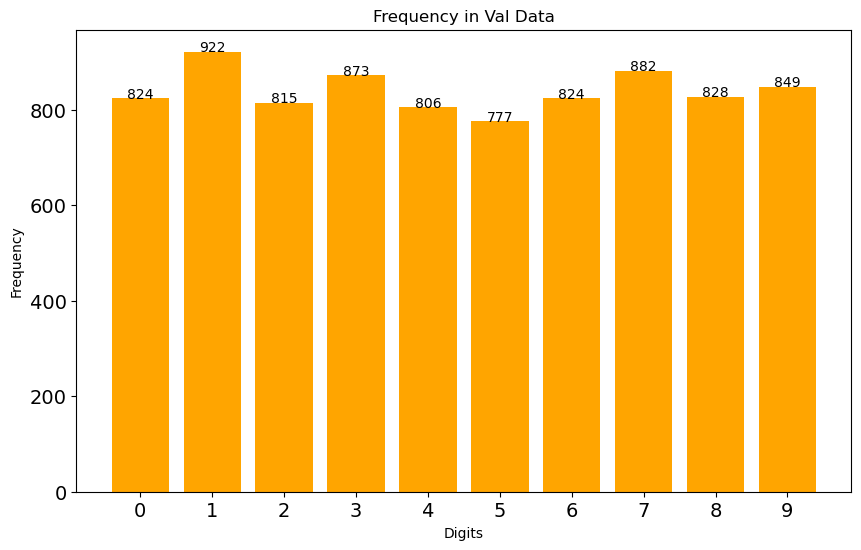

In [40]:
# 显示验证集
fig = plt.figure(figsize=(10, 6)) # 画布大小
fig.add_subplot(111) # 1行1列，位置
counts = train_data.iloc[:val_size,:].groupby("label")["label"].count()
plt.bar(counts.index, counts.values, width=0.8, color='orange') # 柱状图的参数设置

# 循环：为柱状图中的每一个组装增加一个label
for i in counts.index:
    plt.text(i, counts.values[i], str(counts.values[i]), horizontalalignment="center")

plt.tick_params(labelsize=14)
plt.xticks(counts.index)
plt.xlabel("Digits")
plt.ylabel("Frequency")
plt.title("Frequency in Val Data")
plt.savefig("digit_frequency_val.png")
plt.show()

### 6. 显示部分数据集中的数字图片

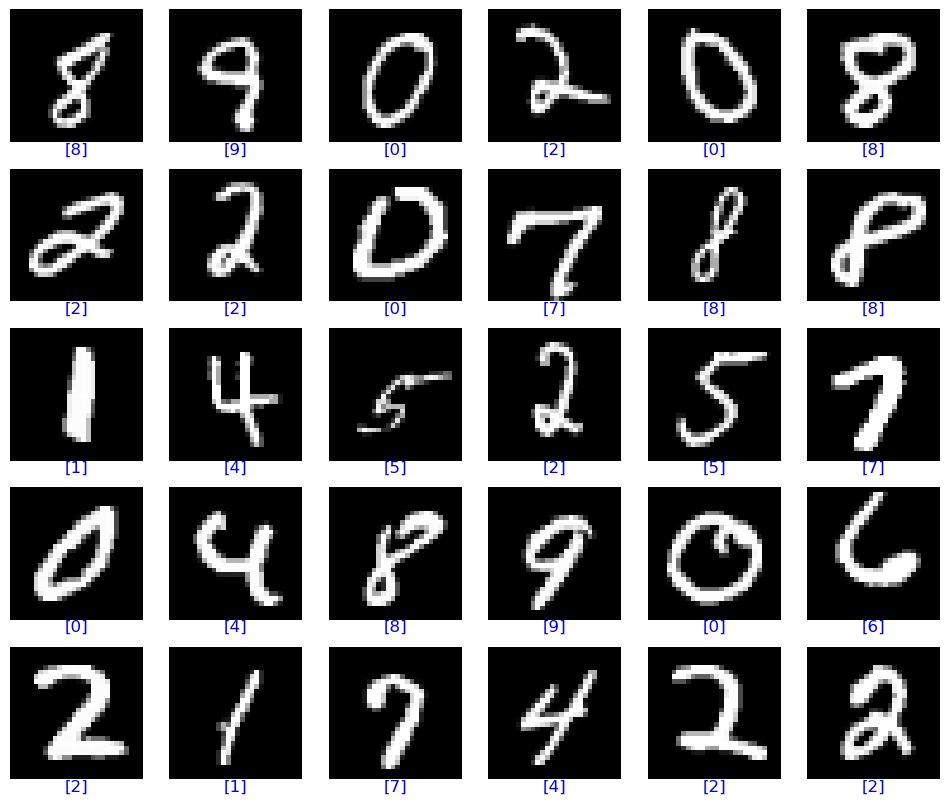

In [42]:
rows = 5 # 行
cols = 6 # 列

fig = plt.figure(figsize=(2*cols, 2*rows))

for i in range(rows * cols):
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(X_train[i].reshape([28, 28]), cmap="gray")
    plt.axis("off")
    plt.title(str(y_train[i]), y=-0.15, color="blue")

plt.savefig("digits.png")

### 7. 构建网络模型

In [43]:
model = models.Sequential()

# Block1
model.add(Conv2D(32, 3, padding='same', input_shape=(28, 28, 1))) # 卷积层
model.add(LeakyReLU()) # 激活层
model.add(Conv2D(32, 3, padding='same')) # 卷积层
model.add(LeakyReLU()) # 激活层
model.add(MaxPool2D(pool_size=(2, 2))) # 池化层

# Block2
model.add(Conv2D(64, 3, padding='same')) # 卷积层
model.add(LeakyReLU()) # 激活层
model.add(Conv2D(64, 3, padding='same')) # 卷积层
model.add(LeakyReLU()) # 激活层
model.add(MaxPool2D(pool_size=(2, 2))) # 池化层
model.add(Dropout(0.25)) # Dropout层

model.add(Flatten()) # 拉平

model.add(Dense(256, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(10, activation='sigmoid'))

### 8. 编译模型

In [46]:
lr = 0.001 # 学习率
loss = "sparse_categorical_crossentropy" # 损失函数
model.compile(Adam(lr=lr), loss=loss, metrics=['accuracy'])

In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18496     
                                                        

### 9. 训练模型

In [48]:
epochs = 10
batch_size = 64
history_1 = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                      validation_data=(X_val, y_val))

Epoch 1/10
525/525 [==============================] - 105s 199ms/step - loss: 0.2185 - accuracy: 0.9326 - val_loss: 0.0605 - val_accuracy: 0.9804
Epoch 2/10
525/525 [==============================] - 98s 186ms/step - loss: 0.0573 - accuracy: 0.9820 - val_loss: 0.0508 - val_accuracy: 0.9842
Epoch 3/10
525/525 [==============================] - 112s 213ms/step - loss: 0.0376 - accuracy: 0.9884 - val_loss: 0.0536 - val_accuracy: 0.9846
Epoch 4/10
525/525 [==============================] - 91s 173ms/step - loss: 0.0315 - accuracy: 0.9901 - val_loss: 0.0416 - val_accuracy: 0.9879
Epoch 5/10
525/525 [==============================] - 98s 186ms/step - loss: 0.0264 - accuracy: 0.9921 - val_loss: 0.0325 - val_accuracy: 0.9899
Epoch 6/10
525/525 [==============================] - 100s 191ms/step - loss: 0.0210 - accuracy: 0.9932 - val_loss: 0.0463 - val_accuracy: 0.9874
Epoch 7/10
525/525 [==============================] - 92s 176ms/step - loss: 0.0190 - accuracy: 0.9936 - val_loss: 0.0407 - val

### 10. 保存模型

In [49]:
model.save("model.h5")

/Users/nancyxie/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### 11. 绘制训练和验证的结果

In [50]:
fig = plt.figure(figsize=(20, 7))

<Figure size 2000x700 with 0 Axes>

In [51]:
fig.add_subplot(121)

<Axes: >

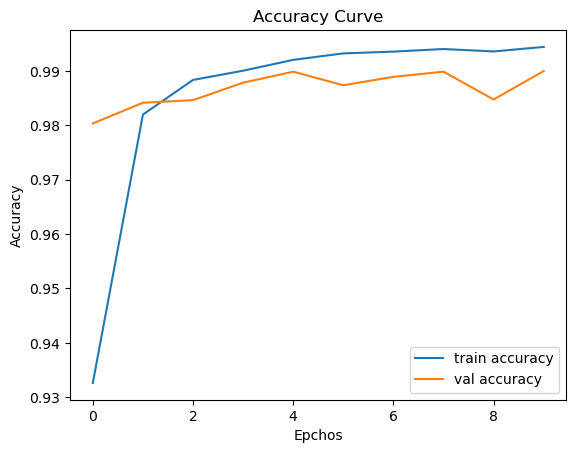

In [52]:
# 1. 从日志中获取训练的accuracy和验证的val_accuracy
plt.plot(history_1.epoch, history_1.history['accuracy'], label="train accuracy")
plt.plot(history_1.epoch, history_1.history['val_accuracy'], label="val accuracy")
plt.title("Accuracy Curve")
plt.xlabel("Epchos")
plt.ylabel("Accuracy")
plt.legend()

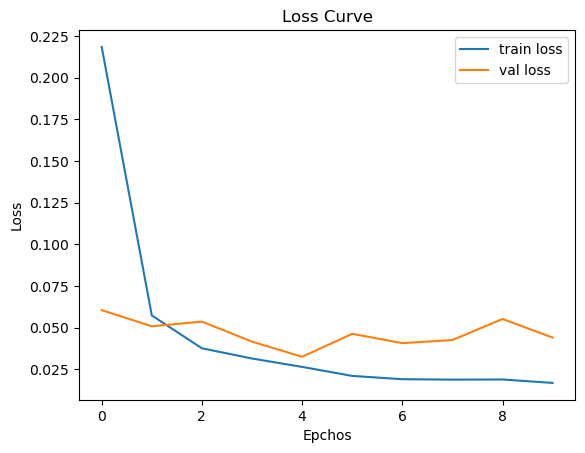

In [53]:
# 2. 从日志中获取需脸的loos和验证的loss
plt.plot(history_1.epoch, history_1.history['loss'], label="train loss")
plt.plot(history_1.epoch, history_1.history['val_loss'], label="val loss")
plt.title("Loss Curve")
plt.xlabel("Epchos")
plt.ylabel("Loss")
plt.legend()